# Geometrical Methods in Machine Learning
## Seminar 5: Topological Data Analysis

In [1]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

import simplicial
import simplicial.drawing

from ripser import lower_star_img
from ripser import Rips
vr = Rips()

import persim

from scipy.ndimage import gaussian_filter

from sklearn.datasets import make_circles
from sklearn.manifold import MDS

import pickle

TEST
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


## 1. Simplicial complexes and homology

#### Simplicial complex definition HERE

**Exercise**: create a simplicial complex consisting of 7 vertices and 6 edges

In [5]:
# create simplicial complex
cmplx = simplicial.SimplicialComplex()

In [6]:
# add 0-simplices (vertices)
v1 = cmplx.addSimplex(id="v1")
v2 = cmplx.addSimplex(id="v2")
v3 = cmplx.addSimplex(id="v3")
v4 = cmplx.addSimplex(id="v4")
v5 = cmplx.addSimplex(id="v5")
v6 = cmplx.addSimplex(id="v6")
v7 = cmplx.addSimplex(id="v7")

In [7]:
# add 1-simplices (edges)
cmplx.addSimplex(['v2', 'v3'], id="e1")
cmplx.addSimplex(['v4', 'v5'], id="e2")
cmplx.addSimplex(['v4', 'v6'], id="e3")
cmplx.addSimplex(['v5', 'v6'], id="e4")
cmplx.addSimplex(['v5', 'v7'], id="e5")
cmplx.addSimplex(['v6', 'v7'], id="e6")

'e6'

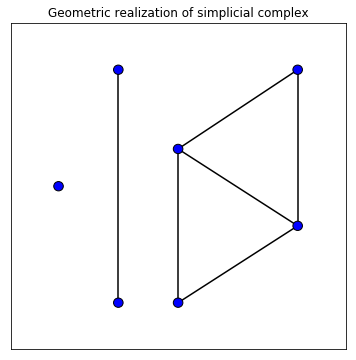

In [8]:
# set coordinates for vertices
em = simplicial.Embedding(cmplx)
em.positionSimplex(v1, (0.0, 0.5))

em.positionSimplex(v2, (0.25, 1.0))
em.positionSimplex(v3, (0.25, 0.0))

em.positionSimplex(v4, (1.0, 1.0))
em.positionSimplex(v5, (0.5, 0.66))
em.positionSimplex(v6, (1.0, 0.33))
em.positionSimplex(v7, (0.5, 0.0))

# draw simplicial complex
fig = plt.figure(figsize=(6,6))
plt.title("Geometric realization of simplicial complex")
simplicial.drawing.draw_complex(cmplx, em)

### Betti numbers

_K-th Betti number_ of topological space is the rank of its' associated _k-th homological group_ and describes the number of holes of dimension $k+1$.

- 0-dimensional holes are connected components
- 1-dimensional holes are loops
- 2-dimensional holes are voids

**Exercise**

Evaluate the dimensionality and non-vanishing Betti numbers of a simplicial complex

In [10]:
# evaluate complex dimension
dim = cmplx.maxOrder()

# evaluate Betti numbers
betti = cmplx.bettiNumbers()

In [11]:
print("Dimension of complex: {}".format(dim))
for key in betti:
    if key <= dim:
        print("Betti-{}: {}".format(str(key), betti[key]))

Dimension of complex: 1
Betti-0: 3
Betti-1: 2


### Modifying the topology of the simplicial complex

**Exercise**

Modify the topology of the simplicial complex by "filling" one of its' 2-dimensional holes by a 2-simplex which is a triangle.

In [12]:
# add 2-simplex (triangle)
cmplx.addSimplex(['e2', 'e3', 'e4'], id="t1")

't1'

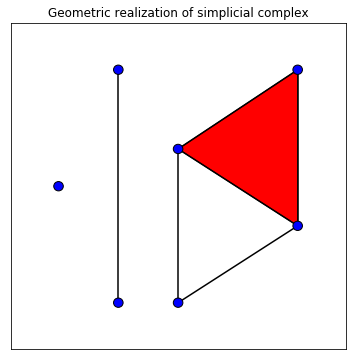

In [13]:
# draw simplicial complex
fig = plt.figure(figsize=(6,6))
plt.title("Geometric realization of simplicial complex")
simplicial.drawing.draw_complex(cmplx, em)

In [14]:
# evaluate complex dimension
dim = cmplx.maxOrder()

# evaluate Betti numbers
betti = cmplx.bettiNumbers()

In [15]:
print("Dimension of complex: {}".format(dim))
for key in betti:
    if key <= dim:
        print("Betti-{}: {}".format(str(key), betti[key]))

Dimension of complex: 2
Betti-0: 3
Betti-1: 1
Betti-2: 0


## 2. Persistent homology, persistent diagrams, Wasserstein distance and stability

In [72]:
# original data
X, y = make_circles(n_samples=200, noise=0.1)
X = X[y==0]

Topology studies data invariant to continous transformations, so topological invariants like (persistent) homology will not change under such class of transformations.

**Exercise**

Apply rotation and dilation transformations to copy of original data.

In [73]:
theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c)))
print(R)

[[ 0.8660254 -0.5      ]
 [ 0.5        0.8660254]]


In [74]:
# transformed data
X_transformed = np.copy(X)
X_transformed[:,0] = X[:,0] * 0.75
X_transformed = np.dot(X_transformed, R)

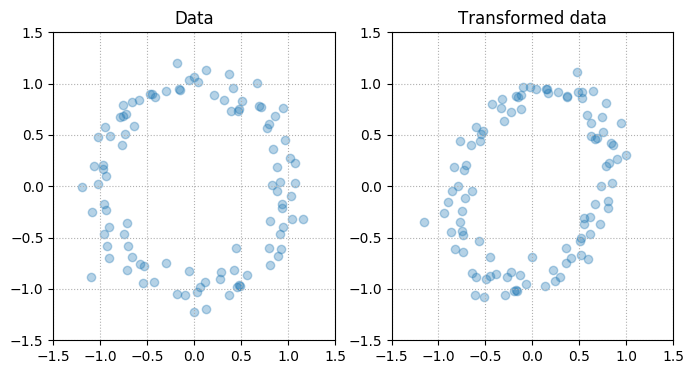

In [75]:
fig = plt.figure(figsize=(8,4))

plt.subplot(121)
plt.title("Data")
plt.grid(linestyle="dotted")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.scatter(X[:,0], X[:,1], alpha=0.33)

plt.subplot(122)
plt.title("Transformed data")
plt.grid(linestyle="dotted")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.scatter(X_transformed[:,0], X_transformed[:,1], alpha=0.33)

plt.show()

#### Vietoris-Rips complex DEFINITION

**Exercise**

Compute persistence diagrams of a filtration of Vietoris-Rips complex built on point cloud data

In [76]:
diagram = vr.fit_transform(X)
diagram_transformed = vr.fit_transform(X_transformed)

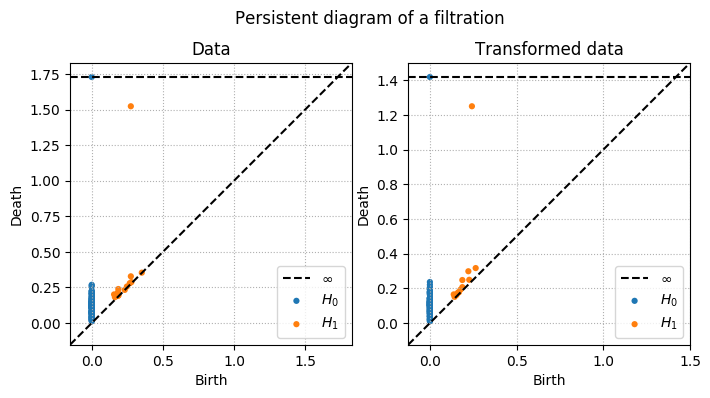

In [77]:
fig = plt.figure(figsize=(8,4))
plt.suptitle("Persistent diagram of a filtration")

plt.grid(linestyle="dotted")

plt.subplot(121)
plt.title("Data")
plt.grid(linestyle="dotted")
vr.plot(diagram)

plt.subplot(122)
plt.title("Transformed data")
plt.grid(linestyle="dotted")
vr.plot(diagram_transformed)

plt.show()

One can define the geometry on the space of persistent diagrams, defining a metric on it. Optimal transport approach is used to compare persistent diagrams which are multisets of intervals of arbitrary cardinality.  

The variants of optimal transport distances are _Wasserstein-2 distance_, and its approximations like _sliced Wasserstein distance_ and _Bollteneck distance_, which is Wasserstein-$\infty$ distance.

**Exercise**

Compute Bottleneck `persim.bottleneck` and sliced Wasserstein distances `persim.sliced_wasserstein` between perisistent diagrams of original and transformed data.

In [78]:
diagram

[array([[0.        , 0.01314169],
        [0.        , 0.01546089],
        [0.        , 0.02121303],
        [0.        , 0.02508628],
        [0.        , 0.02605906],
        [0.        , 0.02887792],
        [0.        , 0.03232088],
        [0.        , 0.03471901],
        [0.        , 0.04059834],
        [0.        , 0.041999  ],
        [0.        , 0.04329617],
        [0.        , 0.04399285],
        [0.        , 0.04786725],
        [0.        , 0.05497716],
        [0.        , 0.05897657],
        [0.        , 0.06076169],
        [0.        , 0.0609494 ],
        [0.        , 0.06796018],
        [0.        , 0.06982931],
        [0.        , 0.07092641],
        [0.        , 0.0714072 ],
        [0.        , 0.07296668],
        [0.        , 0.07370947],
        [0.        , 0.07633018],
        [0.        , 0.07726853],
        [0.        , 0.07961853],
        [0.        , 0.08249826],
        [0.        , 0.08476534],
        [0.        , 0.08510625],
        [0.   

In [79]:
diagram[1].shape

(15, 2)

In [80]:
diagram_transformed[1].shape

(13, 2)

In [83]:
# your code here
persim.bottleneck(diagram[1], diagram_transformed[1])

0.000525742769241333

In [84]:
# your code here
persim.sliced_wasserstein(diagram[1], diagram_transformed[1])

0.0

Bottlneck distance used a single matching between most discriminative pair of points.

**Exercise**

Visualize Bottleneck matching.

In [70]:
# compute Bottleneck distance matching
d, (matching, D) = persim.bottleneck(diagram[1], diagram_transformed[1], matching=True)

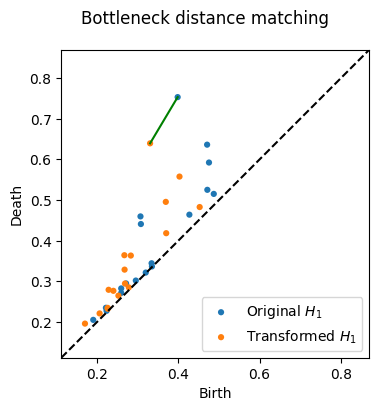

In [71]:
# plot Bottleneck distance matchign
fig = plt.figure(figsize=(8,4))
plt.suptitle("Bottleneck distance matching")
persim.plot.bottleneck_matching(diagram[1], diagram_transformed[1], matching, D, labels=['Original $H_1$', 'Transformed $H_1$'])


For Bottleneck distance stability to small perturbations is theoretically proved.

**Exercise**

Plot Bottleneck distance with respect to different level of Gaussian noise applied to original data.

In [88]:
# original data
X_orig, y = make_circles(n_samples=200, noise=0.0)
X_orig = X_orig[y==0]
diagram_orig = vr.fit_transform(X_orig)

# your code here
dists = []

for noise in np.arange(0, 0.3, 0.02):
    X_noise, y = make_circles(n_samples=200, noise=noise)
    X_noise = X_noise[y==0]
    diagram_noise = vr.fit_transform(X_noise)
    
    dists.append(persim.bottleneck(diagram_orig[1], diagram_noise[1]))

In [89]:
dists

[0.8448958955705166,
 0.08095049113035202,
 0.13110917061567307,
 0.22755324095487595,
 0.22997522354125977,
 0.3016088008880615,
 0.41728317737579346,
 0.46647536754608154,
 0.4348435401916504,
 0.5062373876571655,
 0.6002068519592285,
 0.5915679931640625,
 0.6848070621490479,
 0.7605988383293152,
 0.7992808222770691]

## 3. Persistent homology of graphs

Pipeline is as follows:

1. compute persistent diagrams via Ripser 
2. compute vectorization of diagrams, so-called persistent images
3. apply classifier on 

In [90]:
# load data
X_graphs = pickle.load(open("./data/metric_graphs/X.pkl", "rb"))
y = pickle.load(open("./data/metric_graphs/y_all.pkl", "rb"))
y_dnod = pickle.load(open("./data/metric_graphs/y_d_nod.pkl", "rb"))

y_col = ["a"] * len(y)
y_col = np.array(y_col)

y_col[y==0] = "blue"
y_col[y==2] = "green"
y_col[y==1] = "red"
y_col[y==3] = "yellow"

### Compute persistent diagrams

In [91]:
# add h_1 diagrams only
maxdim = 1
h = 1

rips = Rips(maxdim=maxdim)

diagrams = []
for x in X_graphs:
    diagrams.append(rips.fit_transform(x, distance_matrix=True)[h])

len(diagrams)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


100

### Clusterization

In [ ]:
%%time
n = len(X_graphs)
distances = np.zeros((n, n))

for i in range(0, n):
    for j in range(i+1, n):
        distances[i,j] = persim.sliced_wasserstein(diagrams[i], diagrams[j])
        
distances_symmetrize = distances + distances.T

In [ ]:
distances_symmetrize = distances + distances.T

In [ ]:
mds = MDS(n_components=10, max_iter=3000, eps=1e-9, dissimilarity="precomputed", random_state=1, n_jobs=-1)
X_metric = mds.fit(distances_symmetrize).embedding_

In [ ]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")

plt.scatter(X_metric[:, 0], X_metric[:, 1], c=y_col)
plt.show()

### Vectorization

Persistent diagram is a multiset of intervals of arbitrary length which is can not be handles by methods of machine learning.

One possible to solutions besides providing a metric on the space of persistent diagrams is vectorization of diagrams to a vector of fixed length.

In [92]:
pi = persim.PersImage(spread=0.025, pixels=[32, 32], verbose=False)
pimages = np.array(pi.transform(diagrams))

pimages.shape

(100, 32, 32)

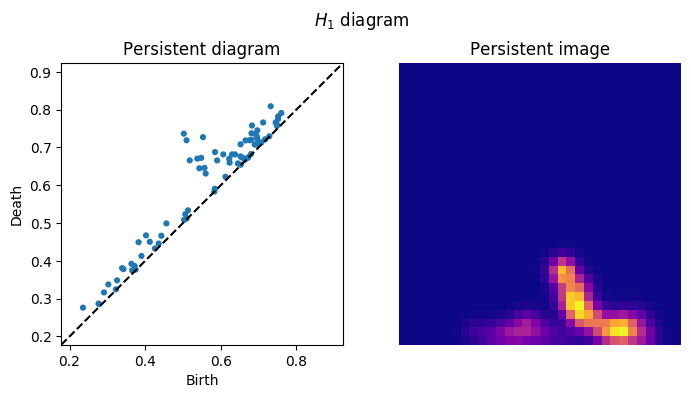

In [93]:
plt.figure(figsize=(8,4))

plt.suptitle("$H_" + str(h) + "$ diagram")

plt.subplot(121)
plt.title("Persistent diagram")
rips.plot(diagrams[0], legend=False)

plt.subplot(122)
plt.title("Persistent image")
pi.show(pimages[0])

plt.show()

### Classification

In [95]:
X_all = pimages.reshape((pimages.shape[0], -1))
y_all = pickle.load(open("./data/metric_graphs/y_all.pkl", "rb")).astype(int)

X_control = X_all[y_all==0]
X_depression = X_all[y_all==1]
X = np.concatenate((X_control, X_depression), axis=0)
y = np.concatenate((np.zeros(25), np.ones(25)), axis=0)

In [96]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

accuracies = []

for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    model = LogisticRegression(penalty='l2', C=10.0, solver='liblinear', random_state=42)

    model.fit(X_train, y_train)
    accuracies.append(model.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

Accuracy: 0.6800 ± 0.1549


## 4. Persistent homology of digital images

Persistence Diagrams with Linear Machine Learning Models (Obayashi, Hiraoka), 2017  
https://arxiv.org/abs/1706.10082

In [97]:
W = 300
sigma1 = 4
sigma2 = 2
t = 0.01

def generate(N, S, W=300, sigma1=4, sigma2=2, t=0.01, bins=64):

    z = np.zeros((N, S, 2))
    for n in range(N):
        z[n, 0] = np.random.uniform(0, W, size=(2))
        for s in range(S-1):
            d_1 = np.random.normal(0, sigma1)
            d_2 = np.random.normal(0, sigma1)
            z[n, s+1, 0] = (z[n, s, 0] + d_1) % W
            z[n, s+1, 1] = (z[n, s, 1] + d_2) % W

    z_r = z.reshape(N*S, 2)
    H, _, _ = np.histogram2d(z_r[:,0], z_r[:,1], bins=bins)
    
    G = gaussian_filter(H, sigma2)
    G[G < t] = 0
    
    return G

### Image generation

Generate 100 images accoring to model A and model B

In [98]:
images = np.zeros((100,64,64))

# class A
N = 100
S = 30

for n in range(50):
    images[n] = generate(N, S)
    
# class B
N = 250
S = 10

for n in range(50):
    images[n+50] = generate(N, S)

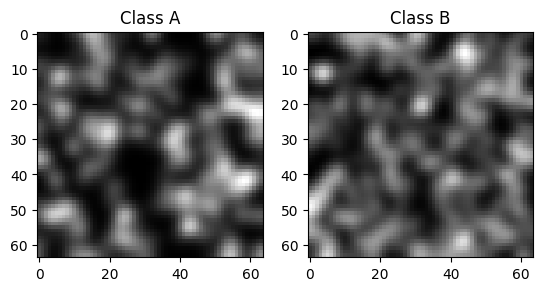

In [120]:
fig = plt.figure()
plt.gray()

ax1 = fig.add_subplot(121)
plt.title("Class A")

ax2 = fig.add_subplot(122)
plt.title("Class B")

ax1.imshow(images[int(np.random.uniform(0, 50))])
ax2.imshow(images[int(np.random.uniform(51, 100))])

plt.show()

### Compute persistent diagrams

In [121]:
diags = []

for i in range(images.shape[0]):
    diags.append(lower_star_img(images[i])[:-1])

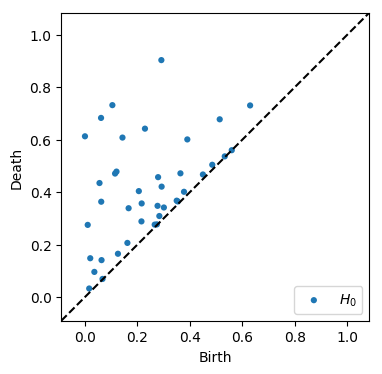

In [126]:
plt.figure(figsize=(4,4))
persim.plot_diagrams(diags[52])

### Vectorization

In [127]:
pi = persim.PersImage(spread=0.025, pixels=[32, 32], verbose=False)
pers_images = np.array(pi.transform(diags))

pers_images.shape

(100, 32, 32)

### Classification

In [128]:
X = images.reshape((pers_images.shape[0], -1))
y = np.concatenate((np.zeros(50), np.ones(50)), axis=0)

y_col = ["b"] * len(y)
y_col = np.array(y_col)

y_col[y==1] = "r"

In [129]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

accuracies = []

for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    model.fit(X_train, y_train)
    accuracies.append(model.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

Accuracy: 0.8460 ± 0.0677


### Clusterization

In [130]:
%%time
n = len(X)
distances_mat = np.zeros((n, n))

for i in range(0, n):
    for j in range(i+1, n):
        distances_mat[i,j] = persim.sliced_wasserstein(diags[i], diags[j])
        
distances_mat_sym = distances_mat + distances_mat.T

CPU times: user 1min 36s, sys: 1.23 s, total: 1min 37s
Wall time: 1min 56s


**Exercise**

Compute MDS embedding, given pairwise distances between data points

In [134]:
mds = MDS(n_components=2, max_iter=3000, random_state=43, n_jobs=1, eps=1e-9)
X_mds = mds.fit_transform(distances_mat_sym)

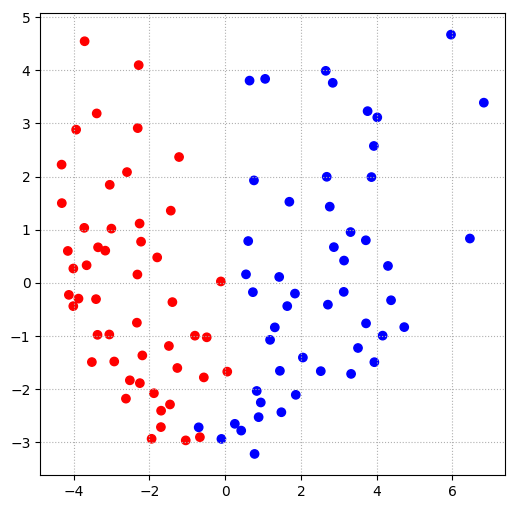

In [135]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")

plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y_col)
plt.show()